In [56]:
import pandas as pd
import numpy as np
import torch
import os
import sys
from tqdm import tqdm, trange

sys.path.append("../")
import biked_commons

from biked_commons.design_evaluation.design_evaluation import *
from biked_commons.data_loading import data_loading
from biked_commons.conditioning import conditioning
from biked_commons.design_evaluation.scoring import *
from biked_commons.validation.linearRegression import *


In [57]:
import os
from torchvision.models import resnet18


# Path to your directory with .png files
directory = "/Users/hanwen/Documents/BikeRepository/pngs"

# List all .png files in the directory
image_files = [f for f in os.listdir(directory) if f.endswith('.png')]

# Extract numbers from filenames (assuming format like '123.png')
existing_numbers = set()
for f in image_files:
    try:
        num = int(f[:-4])  # Remove '.png' and convert to int
        existing_numbers.add(num)
    except ValueError:
        # Skip files that don't match expected naming pattern
        pass

# Define expected set from 1 to 4800 inclusive
expected_files = set(range(1, 4801))

# Find missing files
missing = sorted(expected_files - existing_numbers)

# Print info
print(f"Number of .png files found: {len(image_files)}")
print(f"First 10 files: {sorted(image_files)[:10]}")
print(f"Last 10 files: {sorted(image_files)[-10:]}")
print(f"Missing files count: {len(missing)}")
print(f"Missing files (first 20): {missing[:20]}")

# Assertions to verify counts and presence
assert len(image_files) + len(missing) == 4800, "Mismatch in total files accounted"
assert 1 in existing_numbers, "Missing 1.png image."
assert 4800 in existing_numbers, "Missing 4800.png image."
assert 0 not in missing, "0.png should not be in missing files"

print("✅✅✅ Verified 4800 images (1.png to 4800.png).")


Number of .png files found: 4497
First 10 files: ['1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png']
Last 10 files: ['990.png', '991.png', '992.png', '993.png', '994.png', '995.png', '996.png', '997.png', '998.png', '999.png']
Missing files count: 303
Missing files (first 20): [38, 229, 240, 751, 1047, 1209, 1239, 1321, 1344, 1435, 1457, 1464, 1546, 1731, 1863, 1873, 2019, 2108, 2147, 2163]
✅✅✅ Verified 4800 images (1.png to 4800.png).


In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_1 = data_loading.load_bike_bench_train()
data_2 = data_loading.load_bike_bench_test()
data = pd.concat([data_1, data_2], ignore_index=False)

data_tens = torch.tensor(data.values, dtype=torch.float32, device=device)

In [59]:
import pandas as pd
import sys
import os
from torchvision.models import resnet18


# Add the src/ folder to sys.path
src_path = os.path.expanduser("~/Documents/BikeRepository/Bike-Bench-Temporary/src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Now import the function
from biked_commons.transformation.interface_points import calculate_interace_points_df

# Use your existing DataFrame instead of reading from CSV
df = data  # Assuming your DataFrame is named `data`

# Calculate interface points
labels_df = calculate_interace_points_df(df)

# Save to CSV
labels_path = os.path.expanduser("~/Documents/BikeRepository/labels.csv")
labels_df.to_csv(labels_path, index=False)

print("✅✅✅ Labels calculated and saved.")


✅✅✅ Labels calculated and saved.


In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import os
import pandas as pd

# ---- Dataset class with index checking ----
class BikeDataset(Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        self.image_dir = image_dir
        self.labels = pd.read_csv(label_file).values
        self.transform = transform

        self.valid_indices = [
            i for i in range(len(self.labels))
            if os.path.exists(os.path.join(self.image_dir, f"{i + 1}.png"))
        ]

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        img_path = os.path.join(self.image_dir, f"{actual_idx + 1}.png")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[actual_idx], dtype=torch.float32)
        return image, label

# ---- Transforms (w/ augmentation + normalization for ResNet) ----
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ---- Paths ----
image_dir = os.path.expanduser("~/Documents/BikeRepository/pngs")
label_file = os.path.expanduser("~/Documents/BikeRepository/labels.csv")

# ---- Dataset and DataLoader with train/val split ----
dataset = BikeDataset(image_dir, label_file, transform=transform)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("✅✅✅ Dataset and DataLoaders ready.")


✅✅✅ Dataset and DataLoaders ready.


✅✅✅ ResNet-based model defined.


In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image
import os
import pandas as pd

# ---- Dataset ----
class BikeDataset(Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        self.image_dir = image_dir
        self.labels = pd.read_csv(label_file).values
        self.transform = transform

        self.valid_indices = [
            i for i in range(len(self.labels))
            if os.path.exists(os.path.join(self.image_dir, f"{i + 1}.png"))
        ]

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        img_path = os.path.join(self.image_dir, f"{actual_idx + 1}.png")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[actual_idx], dtype=torch.float32)
        return image, label

# ---- Model ----
class ResNetRegressor(nn.Module):
    def __init__(self, output_size=5):
        super().__init__()
        self.backbone = resnet18(weights='IMAGENET1K_V1') # More modern API
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, output_size)

    def forward(self, x):
        return self.backbone(x)

# ---- Paths and transforms ----
image_dir = os.path.expanduser("~/Documents/BikeRepository/pngs")
label_file = os.path.expanduser("~/Documents/BikeRepository/labels.csv")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.ToTensor()
])

# ---- Dataset and DataLoader ----
dataset = BikeDataset(image_dir, label_file, transform=transform)
train_size = int(0.3 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


print("✅✅✅ Data load complete.")


✅✅✅ Data load complete.


In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image
import os
import pandas as pd

# ---- Model, optimizer, loss ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetRegressor().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# ---- Training loop with early stopping ----
epochs = 30
best_val_loss = float('inf')
epochs_no_improve = 0
n_epochs_stop = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    avg_train_loss = total_loss / len(train_dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * images.size(0)

    avg_val_loss = val_loss / len(val_dataset)

    print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Optional: Save best model
        torch.save(model.state_dict(), "best_model3.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break    

print("✅✅✅ Training complete.")


Epoch 1/30 - Train Loss: 0.2351 - Val Loss: 0.0526
Epoch 2/30 - Train Loss: 0.0450 - Val Loss: 0.0363
Epoch 3/30 - Train Loss: 0.0380 - Val Loss: 0.0350
Epoch 4/30 - Train Loss: 0.0387 - Val Loss: 0.0334
Epoch 5/30 - Train Loss: 0.0351 - Val Loss: 0.0324
Epoch 6/30 - Train Loss: 0.0407 - Val Loss: 0.0388
Epoch 7/30 - Train Loss: 0.0386 - Val Loss: 0.0306
Epoch 8/30 - Train Loss: 0.0348 - Val Loss: 0.0284
Epoch 9/30 - Train Loss: 0.0333 - Val Loss: 0.0296
Epoch 10/30 - Train Loss: 0.0336 - Val Loss: 0.0379
Epoch 11/30 - Train Loss: 0.0328 - Val Loss: 0.0300
Epoch 12/30 - Train Loss: 0.0355 - Val Loss: 0.0303
Epoch 13/30 - Train Loss: 0.0300 - Val Loss: 0.0278
Epoch 14/30 - Train Loss: 0.0348 - Val Loss: 0.0317
Epoch 15/30 - Train Loss: 0.0324 - Val Loss: 0.0285
Epoch 16/30 - Train Loss: 0.0343 - Val Loss: 0.0302
Epoch 17/30 - Train Loss: 0.0336 - Val Loss: 0.0288
Epoch 18/30 - Train Loss: 0.0349 - Val Loss: 0.0307
Early stopping triggered after 18 epochs.
✅✅✅ Training complete.


In [64]:
import torch
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# ---- 1. Load the Best Model ----
# Ensure the model architecture is defined (you can reuse your ResNetRegressor class)
# Create a new instance of the model and move it to the correct device
model.load_state_dict(torch.load("best_model3.pth"))
model.to(device)
print("✅ Best model loaded from 'best_model3.pth'")

# ---- 2. Set Model to Evaluation Mode ----
# This is crucial for getting correct predictions as it disables layers like Dropout
model.eval()


# ---- 3. Run Validation and Collect Predictions ----
all_predictions = []
all_targets = []

# No need to calculate gradients during validation
with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        targets = targets.to(device)

        # Get model predictions
        outputs = model(images)

        # Store predictions and actual targets to calculate metrics later
        all_predictions.append(outputs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate predictions and targets from all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_targets = np.concatenate(all_targets, axis=0)


# ---- 4. Calculate and Report Final Metrics ----
print("\n--- Final Validation Metrics ---")

# Mean Squared Error (already calculated during training, but good to confirm)
final_mse = np.mean((all_targets - all_predictions) ** 2)
print(f"Final Validation MSE: {final_mse:.4f}")

# Mean Absolute Error (MAE) - gives error in the original units
final_mae = mean_absolute_error(all_targets, all_predictions)
print(f"Mean Absolute Error (MAE): {final_mae:.4f}")

# R-squared (Coefficient of Determination) - indicates how much variance is explained
final_r2 = r2_score(all_targets, all_predictions)
print(f"R-squared (R²): {final_r2:.4f}")


# ---- 5. (Optional) Inspect a Few Predictions ----
print("\n--- Example Predictions vs. Actuals ---")
num_examples = min(len(all_predictions), 5) # Show up to 5 examples
for i in range(num_examples):
    print(f"\nSample {i+1}:")
    print(f"  - Predicted: {np.round(all_predictions[i], 2)}")
    print(f"  - Actual:    {np.round(all_targets[i], 2)}")


✅ Best model loaded from 'best_model3.pth'


/var/folders/jc/vxcc04z90k7863z0rdw2wk7c0000gp/T/ipykernel_2110/1705803906.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model3.


--- Final Validation Metrics ---
Final Validation MSE: 0.0278
Mean Absolute Error (MAE): 0.0626
R-squared (R²): -3111451.5000

--- Example Predictions vs. Actuals ---

Sample 1:
  - Predicted: [0.45 0.66 0.35 0.75 0.2 ]
  - Actual:    [0.4  0.44 0.24 0.74 0.17]

Sample 2:
  - Predicted: [0.4  0.53 0.18 0.54 0.21]
  - Actual:    [0.42 0.43 0.23 0.73 0.17]

Sample 3:
  - Predicted: [0.43 0.59 0.2  0.73 0.21]
  - Actual:    [0.41 0.5  0.26 0.77 0.17]

Sample 4:
  - Predicted: [0.39 0.48 0.16 0.68 0.19]
  - Actual:    [0.4  0.41 0.23 0.73 0.17]

Sample 5:
  - Predicted: [0.41 0.45 0.19 0.66 0.19]
  - Actual:    [0.4  0.43 0.26 0.77 0.17]


In [65]:
import torch
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# ---- 1. Load the Best Model ----
# Ensure the model architecture is defined (you can reuse your ResNetRegressor class)
# Create a new instance of the model and move it to the correct device
model.load_state_dict(torch.load("best_model3.pth"))
model.to(device)
print("✅ Best model loaded from 'best_model3.pth'")


# ---- 2. Set Model to Evaluation Mode ----
# This is crucial for getting correct predictions as it disables layers like Dropout
model.eval()


# ---- 3. Run Validation and Collect Predictions ----
all_predictions = []
all_targets = []

# No need to calculate gradients during validation
with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        targets = targets.to(device)

        # Get model predictions
        outputs = model(images)

        # Store predictions and actual targets to calculate metrics later
        all_predictions.append(outputs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate predictions and targets from all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_targets = np.concatenate(all_targets, axis=0)


# ---- 4. Calculate and Report Final Metrics ----
print("\n--- Final Validation Metrics ---")

# Mean Squared Error (already calculated during training, but good to confirm)
final_mse = np.mean((all_targets - all_predictions) ** 2)
print(f"Final Validation MSE: {final_mse:.4f}")

# Mean Absolute Error (MAE) - gives error in the original units
final_mae = mean_absolute_error(all_targets, all_predictions)
print(f"Mean Absolute Error (MAE): {final_mae:.4f}")

# R-squared (Coefficient of Determination) - indicates how much variance is explained
final_r2 = r2_score(all_targets, all_predictions)
print(f"R-squared (R²): {final_r2:.4f}")


# ---- 5. (Optional) Inspect a Few Predictions ----
print("\n--- Example Predictions vs. Actuals ---")
num_examples = min(len(all_predictions), 5) # Show up to 5 examples
for i in range(num_examples):
    print(f"\nSample {i+1}:")
    print(f"  - Predicted: {np.round(all_predictions[i], 2)}")
    print(f"  - Actual:    {np.round(all_targets[i], 2)}")



✅ Best model loaded from 'best_model3.pth'


/var/folders/jc/vxcc04z90k7863z0rdw2wk7c0000gp/T/ipykernel_2110/2746514480.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model3.


--- Final Validation Metrics ---
Final Validation MSE: 0.0278
Mean Absolute Error (MAE): 0.0631
R-squared (R²): -3224223.5000

--- Example Predictions vs. Actuals ---

Sample 1:
  - Predicted: [0.45 0.67 0.32 0.76 0.19]
  - Actual:    [0.4  0.44 0.24 0.74 0.17]

Sample 2:
  - Predicted: [0.46 0.49 0.24 0.62 0.16]
  - Actual:    [0.42 0.43 0.23 0.73 0.17]

Sample 3:
  - Predicted: [0.42 0.54 0.21 0.71 0.18]
  - Actual:    [0.41 0.5  0.26 0.77 0.17]

Sample 4:
  - Predicted: [0.39 0.46 0.17 0.72 0.19]
  - Actual:    [0.4  0.41 0.23 0.73 0.17]

Sample 5:
  - Predicted: [0.44 0.48 0.22 0.63 0.17]
  - Actual:    [0.4  0.43 0.26 0.77 0.17]


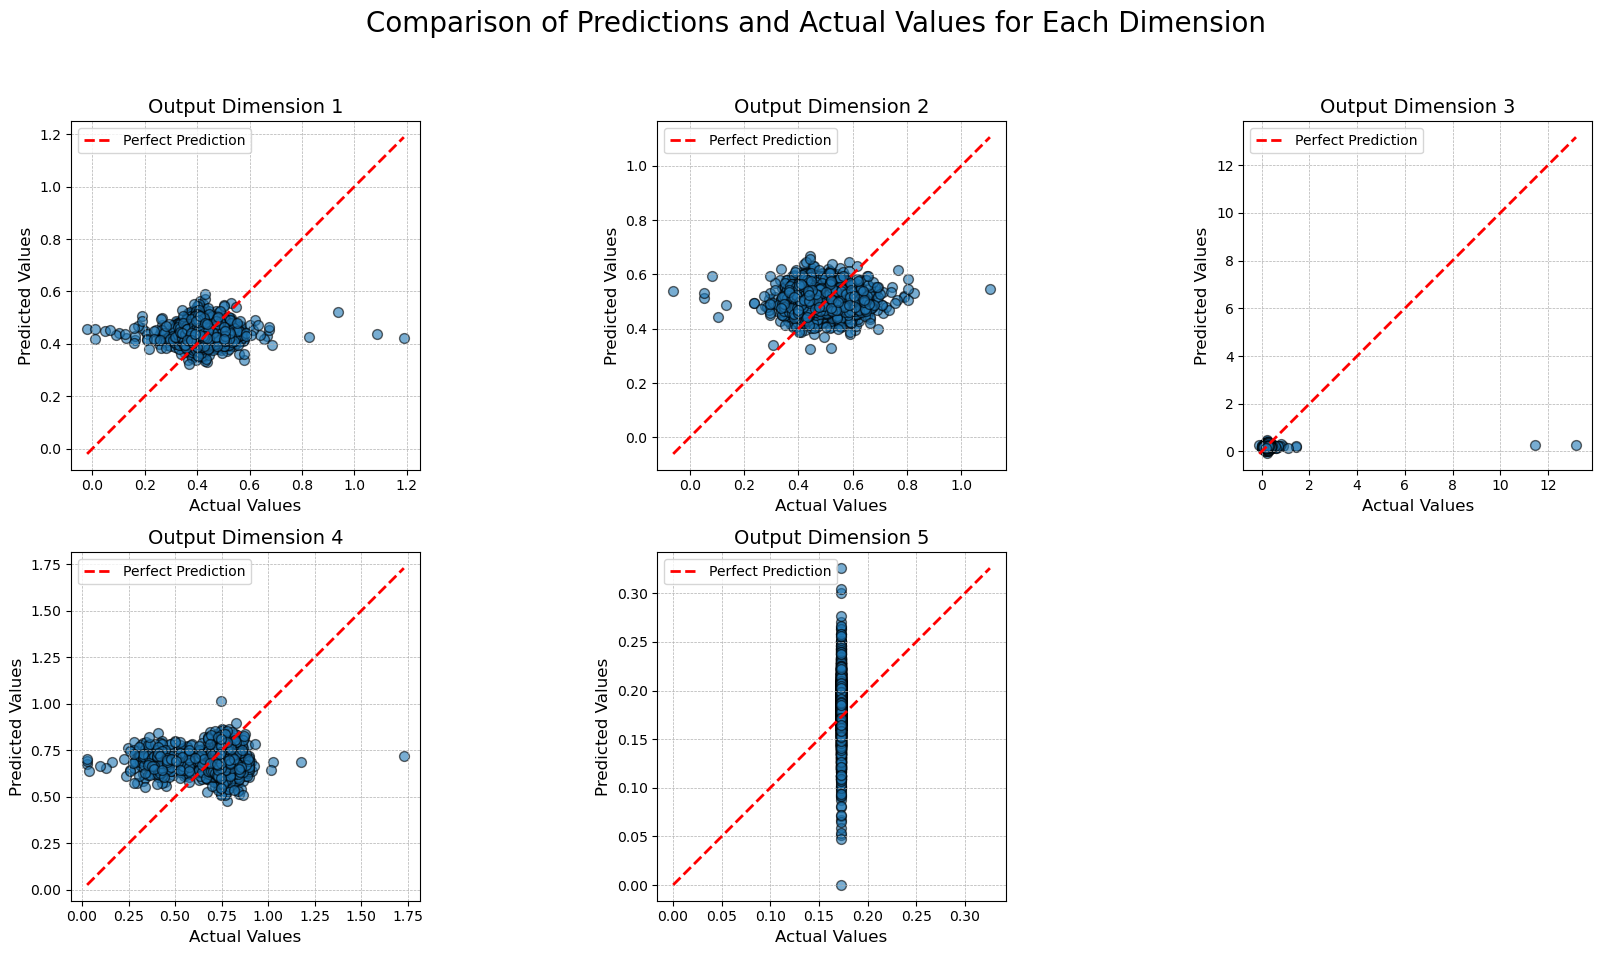

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# ---- 1. Create a plot to visualize predictions vs. actuals ----
# Since the output has 5 dimensions, we can create a subplot for each.
num_dimensions = all_targets.shape[1]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # Flatten the 2x3 grid to a 1D array for easy iteration

for i in range(num_dimensions):
    ax = axes[i]
    
    # Scatter plot of actual vs. predicted values
    ax.scatter(all_targets[:, i], all_predictions[:, i], alpha=0.6, edgecolors='k', s=50)
    
    # Add a line for perfect predictions (y=x)
    # We find the min and max of all data to set the limits for the perfect line
    min_val = min(all_targets[:, i].min(), all_predictions[:, i].min())
    max_val = max(all_targets[:, i].max(), all_predictions[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    ax.set_xlabel("Actual Values", fontsize=12)
    ax.set_ylabel("Predicted Values", fontsize=12)
    ax.set_title(f"Output Dimension {i+1}", fontsize=14)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_aspect('equal', 'box')

# Hide any unused subplots if the number of dimensions is not 6
for i in range(num_dimensions, len(axes)):
    fig.delaxes(axes[i])

fig.suptitle("Comparison of Predictions and Actual Values for Each Dimension", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

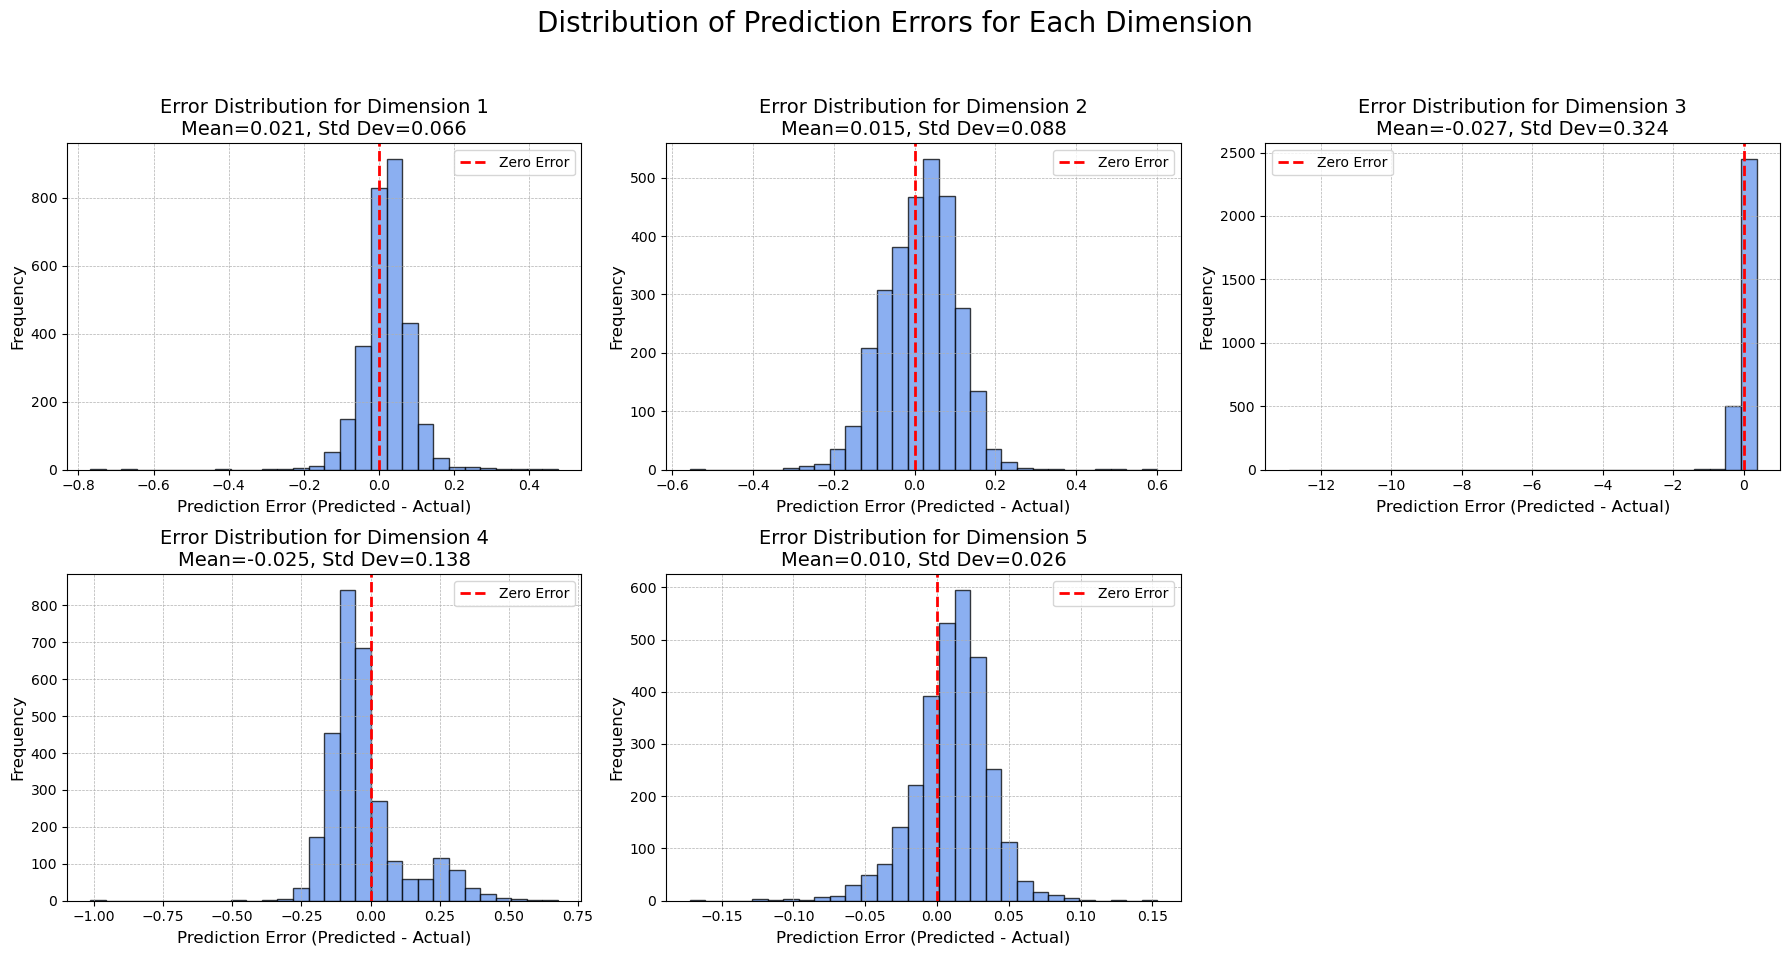

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# ---- 1. Calculate the differences (errors) ----
# This is the core of what we want to visualize.
differences = all_predictions - all_targets

# ---- 2. Create plots to visualize the distribution of these differences ----
num_dimensions = differences.shape[1]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # Flatten the 2x3 grid to a 1D array for easy iteration

for i in range(num_dimensions):
    ax = axes[i]
    
    # Plot a histogram of the differences for the current dimension
    ax.hist(differences[:, i], bins=30, alpha=0.75, color='cornflowerblue', edgecolor='k')
    
    # Add a vertical line at zero, which represents a perfect prediction
    ax.axvline(0, color='r', linestyle='--', lw=2, label='Zero Error')
    
    # Calculate and display mean and standard deviation of the errors
    mean_error = np.mean(differences[:, i])
    std_error = np.std(differences[:, i])
    
    ax.set_xlabel("Prediction Error (Predicted - Actual)", fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.set_title(f"Error Distribution for Dimension {i+1}\nMean={mean_error:.3f}, Std Dev={std_error:.3f}", fontsize=14)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Hide any unused subplots
for i in range(num_dimensions, len(axes)):
    fig.delaxes(axes[i])

fig.suptitle("Distribution of Prediction Errors for Each Dimension", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()


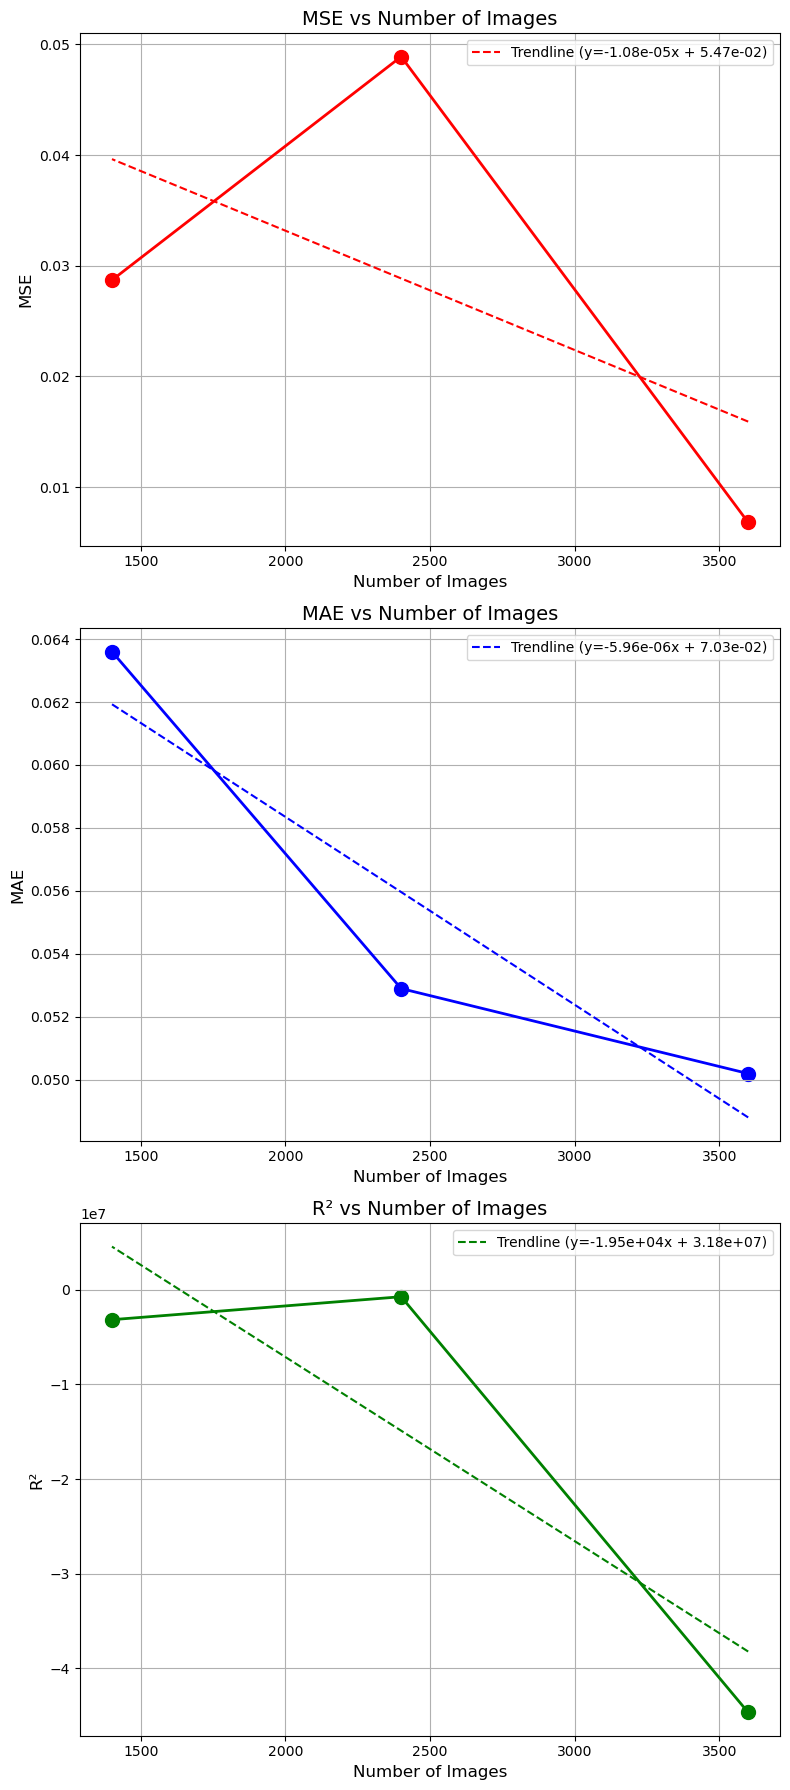

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data
image_counts = [3600, 2400, 1400]
mse_values = [0.0068, 0.0489, 0.0287]
mae_values = [0.0502, 0.0529, 0.0636]
r_squared_values = [-44661296.0000, -728828.9375, -3155171.0000]

# Create three separate plots
fig, axs = plt.subplots(3, 1, figsize=(8, 18))

# Function to add a trendline (linear fit)
def add_trendline(ax, x, y, color):
    # Fit line to data
    slope, intercept = np.polyfit(x, y, 1)
    # Create the trendline (y = mx + b)
    trendline = np.poly1d((slope, intercept))
    ax.plot(x, trendline(x), color=color, linestyle='--', label=f'Trendline (y={slope:.2e}x + {intercept:.2e})')

# Plot for MSE
axs[0].scatter(image_counts, mse_values, color='red', s=100)
axs[0].plot(image_counts, mse_values, color='red', marker='o', linestyle='-', linewidth=2)  # Line connecting the dots
add_trendline(axs[0], image_counts, mse_values, 'red')
axs[0].set_title("MSE vs Number of Images", fontsize=14)
axs[0].set_xlabel("Number of Images", fontsize=12)
axs[0].set_ylabel("MSE", fontsize=12)
axs[0].grid(True)
axs[0].legend()

# Plot for MAE
axs[1].scatter(image_counts, mae_values, color='blue', s=100)
axs[1].plot(image_counts, mae_values, color='blue', marker='o', linestyle='-', linewidth=2)  # Line connecting the dots
add_trendline(axs[1], image_counts, mae_values, 'blue')
axs[1].set_title("MAE vs Number of Images", fontsize=14)
axs[1].set_xlabel("Number of Images", fontsize=12)
axs[1].set_ylabel("MAE", fontsize=12)
axs[1].grid(True)
axs[1].legend()

# Plot for R²
axs[2].scatter(image_counts, r_squared_values, color='green', s=100)
axs[2].plot(image_counts, r_squared_values, color='green', marker='o', linestyle='-', linewidth=2)  # Line connecting the dots
add_trendline(axs[2], image_counts, r_squared_values, 'green')
axs[2].set_title("R² vs Number of Images", fontsize=14)
axs[2].set_xlabel("Number of Images", fontsize=12)
axs[2].set_ylabel("R²", fontsize=12)
axs[2].grid(True)
axs[2].legend()

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show plots
plt.show()
